# iGaming retention test

> Data Generator A/B groups using Python
> 
> Two group of people splitted, between treatment and control group

In [1]:
# Step 1: importing libraries, setting seed and number of players
import numpy as np
import pandas as pd

In [2]:
np.random.seed(69)
n = 70000

In [3]:
# Step 2: Group assignment
groups = np.random.choice(['control', 'treatment'], size=n, p=[0.5, 0.5])

# Step 3: Base engagement metrics (for both groups)
sessions = np.random.poisson(lam=5, size=n)
deposits = np.random.gamma(shape=2, scale=50, size=n)

# Step 4: Treatment group effect with more sessions and deposits
sessions += np.where(groups == 'treatment', np.random.randint(0, 3, size=n), 0)
deposits += np.where(groups == 'treatment', np.random.normal(15, 10, size=n), 0)

# Step 5: Feature usage (higher in treatment)
feature_used = np.where(groups == 'treatment',
                        np.random.binomial(1, 0.7, size=n),
                        np.random.binomial(1, 0.4, size=n))

In [4]:
# Step 6: Churn generation: different in treatment group
base_churn = np.random.binomial(1, 0.45, size=n)
treatment_adjustment = np.where(groups == 'treatment', -0.1, 0)
churn_prob = np.clip(0.45 + treatment_adjustment - 0.02 * feature_used - 0.01 * (sessions > 6), 0, 1)
churn = np.random.binomial(1, churn_prob)

In [ ]:
# Step 7: assemble dataset and print it
df = pd.DataFrame({
    'user_id': np.arange(1, n+1),
    'group': groups,
    'sessions': sessions,
    'deposits': np.round(deposits, 2),
    'feature_used': feature_used,
    'churn': churn
})

df.to_csv('simulated_users.csv', index=False)
print("✅ Dataset saved to simulated_users.csv")

# A/B Test Analysis
# Checking the behaviour and results for both groups: treated and controlled 

In [7]:
# Step 1: importing missing libraries
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [14]:
# Step 2: reading csv file generated previously
df = pd.read_csv('simulated_users.csv')

display(df)

,user_id,group,sessions,deposits,feature_used,churn
0,1,control,2,176.25,1,1
1,2,treatment,7,119.93,1,1
2,3,control,4,85.04,0,1
3,4,treatment,5,279.48,0,0
4,5,treatment,5,57.19,1,0
...,...,...,...,...,...,...
69995,69996,treatment,5,38.98,1,1
69996,69997,treatment,7,64.57,1,1
69997,69998,control,5,159.79,1,1
69998,69999,control,2,101.41,0,1


In [16]:
# Step 3: defining Retention = 1 - churn
df['retained'] = 1 - df['churn']

# Step 4: group stats calculations
summary = df.groupby('group')['retained'].mean().reset_index()
summary['retention_rate_%'] = (summary['retained'] * 100).round(2)
display(summary)

,group,retained,retention_rate_%
0,control,0.568116,56.81
1,treatment,0.666199,66.62


In [24]:
# Step 3: significance test using Chi-square
contingency = pd.crosstab(df['group'], df['retained'])
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi-square: {chi2:.2f}\nP-value: {p:.4f}")

Chi-square: 712.02
P-value: 0.0000


/tmp/ipykernel_7923/984571590.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='group', y='retention_rate_%', data=summary, palette='viridis')


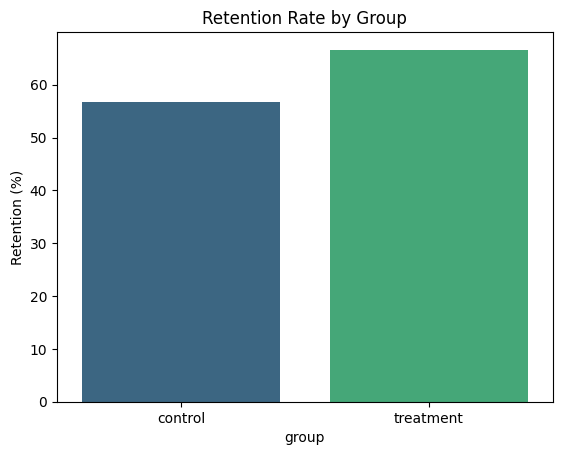

In [25]:
# Step 4: Plot retention comparison
sns.barplot(x='group', y='retention_rate_%', data=summary, palette='viridis')
plt.title('Retention Rate by Group')
plt.ylabel('Retention (%)')
plt.savefig('retention_rates.png', bbox_inches='tight')
plt.show()

# Churn model
> for Retention on A/B Test output
> 
> using Machine Learning model

In [26]:
# Step 1: Importing missing libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

In [28]:
# Step 2: Loading data and defining churn model with y and x
df = pd.read_csv('simulated_users.csv')

X = df[['sessions', 'deposits', 'feature_used']]
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
# Step 3: Model implementation
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.3f}")
print(classification_report(y_test, y_pred))

AUC: 0.531
              precision    recall  f1-score   support

           0       0.62      1.00      0.77     13014
           1       0.00      0.00      0.00      7986

    accuracy                           0.62     21000
   macro avg       0.31      0.50      0.38     21000
weighted avg       0.38      0.62      0.47     21000



/home/pietro/Documenti/VirtualEnvironments/venvJupyter/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/pietro/Documenti/VirtualEnvironments/venvJupyter/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/pietro/Documenti/VirtualEnvironments/venvJupyter/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

/tmp/ipykernel_7923/2078908096.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=coef, palette='coolwarm')


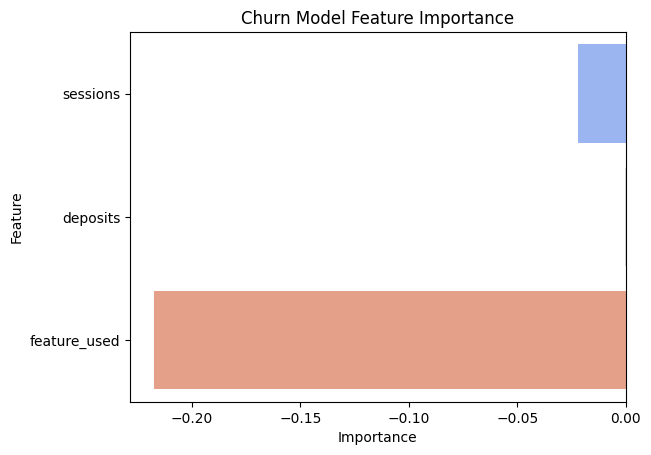

In [33]:
# Step 4: Feature importance, and plot
coef = pd.DataFrame({'Feature': X.columns, 'Importance': model.coef_[0]})
sns.barplot(x='Importance', y='Feature', data=coef, palette='coolwarm')
plt.title('Churn Model Feature Importance')
plt.savefig('churn_probability.png', bbox_inches='tight')
plt.show()